In [70]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline
from sklearn.linear_model import LogisticRegression
import operator
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# Classes and Functions

In [43]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import math

class ClusterModel(object):
    
    def __init__ (self, dfData, modelObj, catCols=None, contCols=None, **modelParams):
        self.X = dfData
        self.modelParams = modelParams
        self.modelParams = modelObj.set_params(**self.modelParams)
        self.contCols = contCols
        self.catCols = catCols
        self.initValues()
        self.initSilhouette()
        
    def initValues(self):
        self.Xnorm = normalize(self.X)
        self.modelFit = self.modelParams.fit(self.Xnorm)
        self.Xclust = self.X.copy()
        self.Xclust['cluster'] = self.modelFit.labels_

    def initSilhouette(self):
        XA, XB = train_test_split(
        self.Xnorm,
        test_size=0.5,
        random_state=42)

        X1, X2 = train_test_split(
            XA,
            test_size=0.5,
            random_state=42)

        X3, X4 = train_test_split(
            XB,
            test_size=0.5,
            random_state=42)

        self.silScores = []
        for sample in [X1, X2, X3, X4]:
            modelSample = self.modelParams.fit(sample)
            labels = modelSample.labels_
            silScore = metrics.silhouette_score(sample, labels, metric='euclidean')
            self.silScores.append(silScore)
   
    def silScore(self):
        print (self.silScores)
        print("RANGE: {}".format(max(self.silScores)-min(self.silScores)))
        print("CLUSTERS: {}".format(numClusters))
       
    def showCatGraphs(self):
        for cat in self.catCols:
            sns.set(style="whitegrid")
            g = sns.catplot(x='cluster',
                hue=cat,
                data=self.Xclust,kind='count')
    
    def showContBoxPlots(self,gridCols=2):
        numOfCols = len(self.contCols)
        rows = math.ceil(numOfCols/2)
        
        for catCol in self.catCols:
            fig = plt.figure(figsize=(30,80))
            for idx,contCol in enumerate(self.contCols):
                ax = fig.add_subplot(rows, gridCols, idx+1)
                ax.set_title("\"{}\"per Cluster".format(contCol))
                ax.yaxis.label.set_size(25)
                ax.yaxis.set_tick_params(labelsize = 20)
                ax.xaxis.label.set_size(25)
                ax.xaxis.set_tick_params(labelsize = 20)
                sns.boxplot(y=contCol,
                        x='cluster', 
                        hue=catCol,
                        palette="Set2",
                        data=self.Xclust, ax=ax)
            plt.show()

# Data

https://github.com/llimllib/bostonmarathon/tree/master/results/2013

In [5]:
df = pd.read_csv('results.csv',error_bad_lines=False)

In [6]:
# Make sure the number of rows divides evenly into four samples.
rows = df.shape[0] - df.shape[0] % 4
df = df.iloc[:rows, :]

In [7]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df.head()

height has been deprecated.



,25k,age,name,division,10k,gender,half,official,bib,ctz,country,overall,pace,state,30k,5k,genderdiv,20k,35k,city,40k
0,49.87,28,"Cassidy, Josh R.",9,18.18,M,40.93,90.90,W1,NaN,CAN,9,3.47,ON,62.07,8.90,9,38.80,74.73,Toronto,85.55
1,77.27,30,"Korir, Wesley",5,30.90,M,64.90,132.50,1,NaN,KEN,5,5.07,NaN,92.97,15.90,5,61.52,108.78,Kenya,124.77
2,77.23,23,"Desisa, Lelisa",1,30.90,M,64.92,130.37,2,NaN,ETH,1,4.98,NaN,92.72,15.93,1,61.53,108.68,Ambo,123.78
3,50.50,32,"Fearnley, Kurt H.",5,18.73,M,42.00,88.43,W2,NaN,AUS,5,3.38,NaN,61.35,8.98,5,39.88,73.00,Hamilton,83.43
4,48.75,39,"Hokinoue, Kota",3,18.18,M,40.57,87.22,W3,NaN,JPN,3,3.33,NaN,59.92,8.92,3,38.55,71.68,Iizuka,81.88


In [8]:
df.describe()

,age,division,official,overall,pace,genderdiv
count,16164.000000,16164.000000,16164.000000,16164.000000,16164.000000,16164.000000
mean,41.638332,1100.967025,208.159470,8429.373422,7.947398,4351.684732
std,10.351311,942.114816,23.743608,5052.024116,0.905739,2772.398239
min,18.000000,1.000000,85.530000,1.000000,3.270000,1.000000
25%,34.000000,363.000000,191.727500,4061.750000,7.320000,2032.750000
50%,42.000000,842.000000,209.225000,8247.500000,7.980000,4113.500000
75%,49.000000,1560.000000,225.230000,12662.250000,8.600000,6316.000000
max,80.000000,3834.000000,284.230000,17598.000000,10.850000,10648.000000


# Data Cleaning

## Drop all Categorical but Gender

In [9]:
dfDrop = df.copy()
dfDrop = dfDrop.drop(['name',
       'state',
       'bib',
       'ctz',
       'country',
       'state',
       'city'], axis=1)

## Encode Gender (M = 1)

In [10]:
dfEncGen = dfDrop.copy()
dfEncGen['gender'] = np.where(dfEncGen['gender'].str.contains('M'),1,0)

## Convert Non-numeric to Numeric

In [11]:
dfEncGen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16164 entries, 0 to 16163
Data columns (total 15 columns):
25k          16164 non-null object
age          16164 non-null int64
division     16164 non-null int64
10k          16164 non-null object
gender       16164 non-null int64
half         16164 non-null object
official     16164 non-null float64
overall      16164 non-null int64
pace         16164 non-null float64
30k          16164 non-null object
5k           16164 non-null object
genderdiv    16164 non-null int64
20k          16164 non-null object
35k          16164 non-null object
40k          16164 non-null object
dtypes: float64(2), int64(5), object(8)
memory usage: 1.8+ MB


In [12]:
dfNum = dfEncGen.copy()
numCols = ['25k','10k','half','30k','5k','20k','35k','40k']
numCols = ['25k','10k','half','30k','5k','20k','35k','40k']
for c in numCols:
    dfNum[c] = pd.to_numeric(dfNum[c], errors='coerce')

## Find and Drop Nulls

In [13]:
total = dfNum.isnull().sum().sort_values(ascending=False)
percent = (dfNum.isnull().sum()/dfNum.isnull().count()).sort_values(ascending=False)
dfNum_missingData = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
display(dfNum_missingData.head(20))
dfNum.isnull().sum().max()

,Total,Percent
5k,66,0.004083
10k,26,0.001609
25k,23,0.001423
35k,21,0.001299
40k,17,0.001052
20k,17,0.001052
30k,17,0.001052
half,16,0.000990
genderdiv,0,0.000000
pace,0,0.000000


66

In [14]:
dfNoNulls = dfNum.copy()
dfNoNulls.dropna(inplace=True)
print ("Before Dropping Nulls: ", df.shape[0])
print ("After Dropping Nulls: ", dfNoNulls.shape[0])
print ("Rows Removed: ", df.shape[0] - dfNoNulls.shape[0])
print ("Percent Removed: {:.0%}".format(1-(dfNoNulls.shape[0])/df.shape[0]))   

Before Dropping Nulls:  16164
After Dropping Nulls:  16054
Rows Removed:  110
Percent Removed: 1%


# Define X

In [17]:
X = dfNoNulls.copy()
Xnorm = normalize(X)

# k-means

## Elbow Method to Identify Number of Clusters

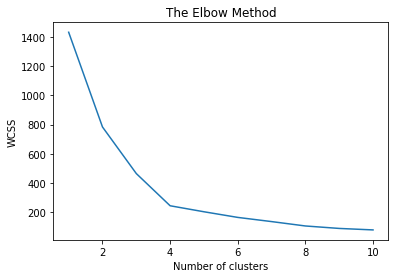

In [18]:
wcss = []
prevInert = 0
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(Xnorm)
    prevInert=kmeans.inertia_
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## Create k-means Object

In [58]:
cols = np.array(dfNoNulls.columns.values)
catCols = ['gender']
contCols = cols[cols!='gender']

numClusters = 4
clustObj = KMeans()
kmeansParams = {'n_clusters': numClusters,
              'random_state': 42}

In [59]:
kmeansModel = ClusterModel(X, KMeans(), catCols, contCols, **kmeansParams)

## Check Silhouette Scores

In [40]:
kmeansModel.silScore()

[0.63326765027740684, 0.63179673293316829, 0.63075493267445082, 0.63003781363974287]
RANGE: 0.003229836637663963
CLUSTERS: 4


## Continuous Feature Plots per Cluster

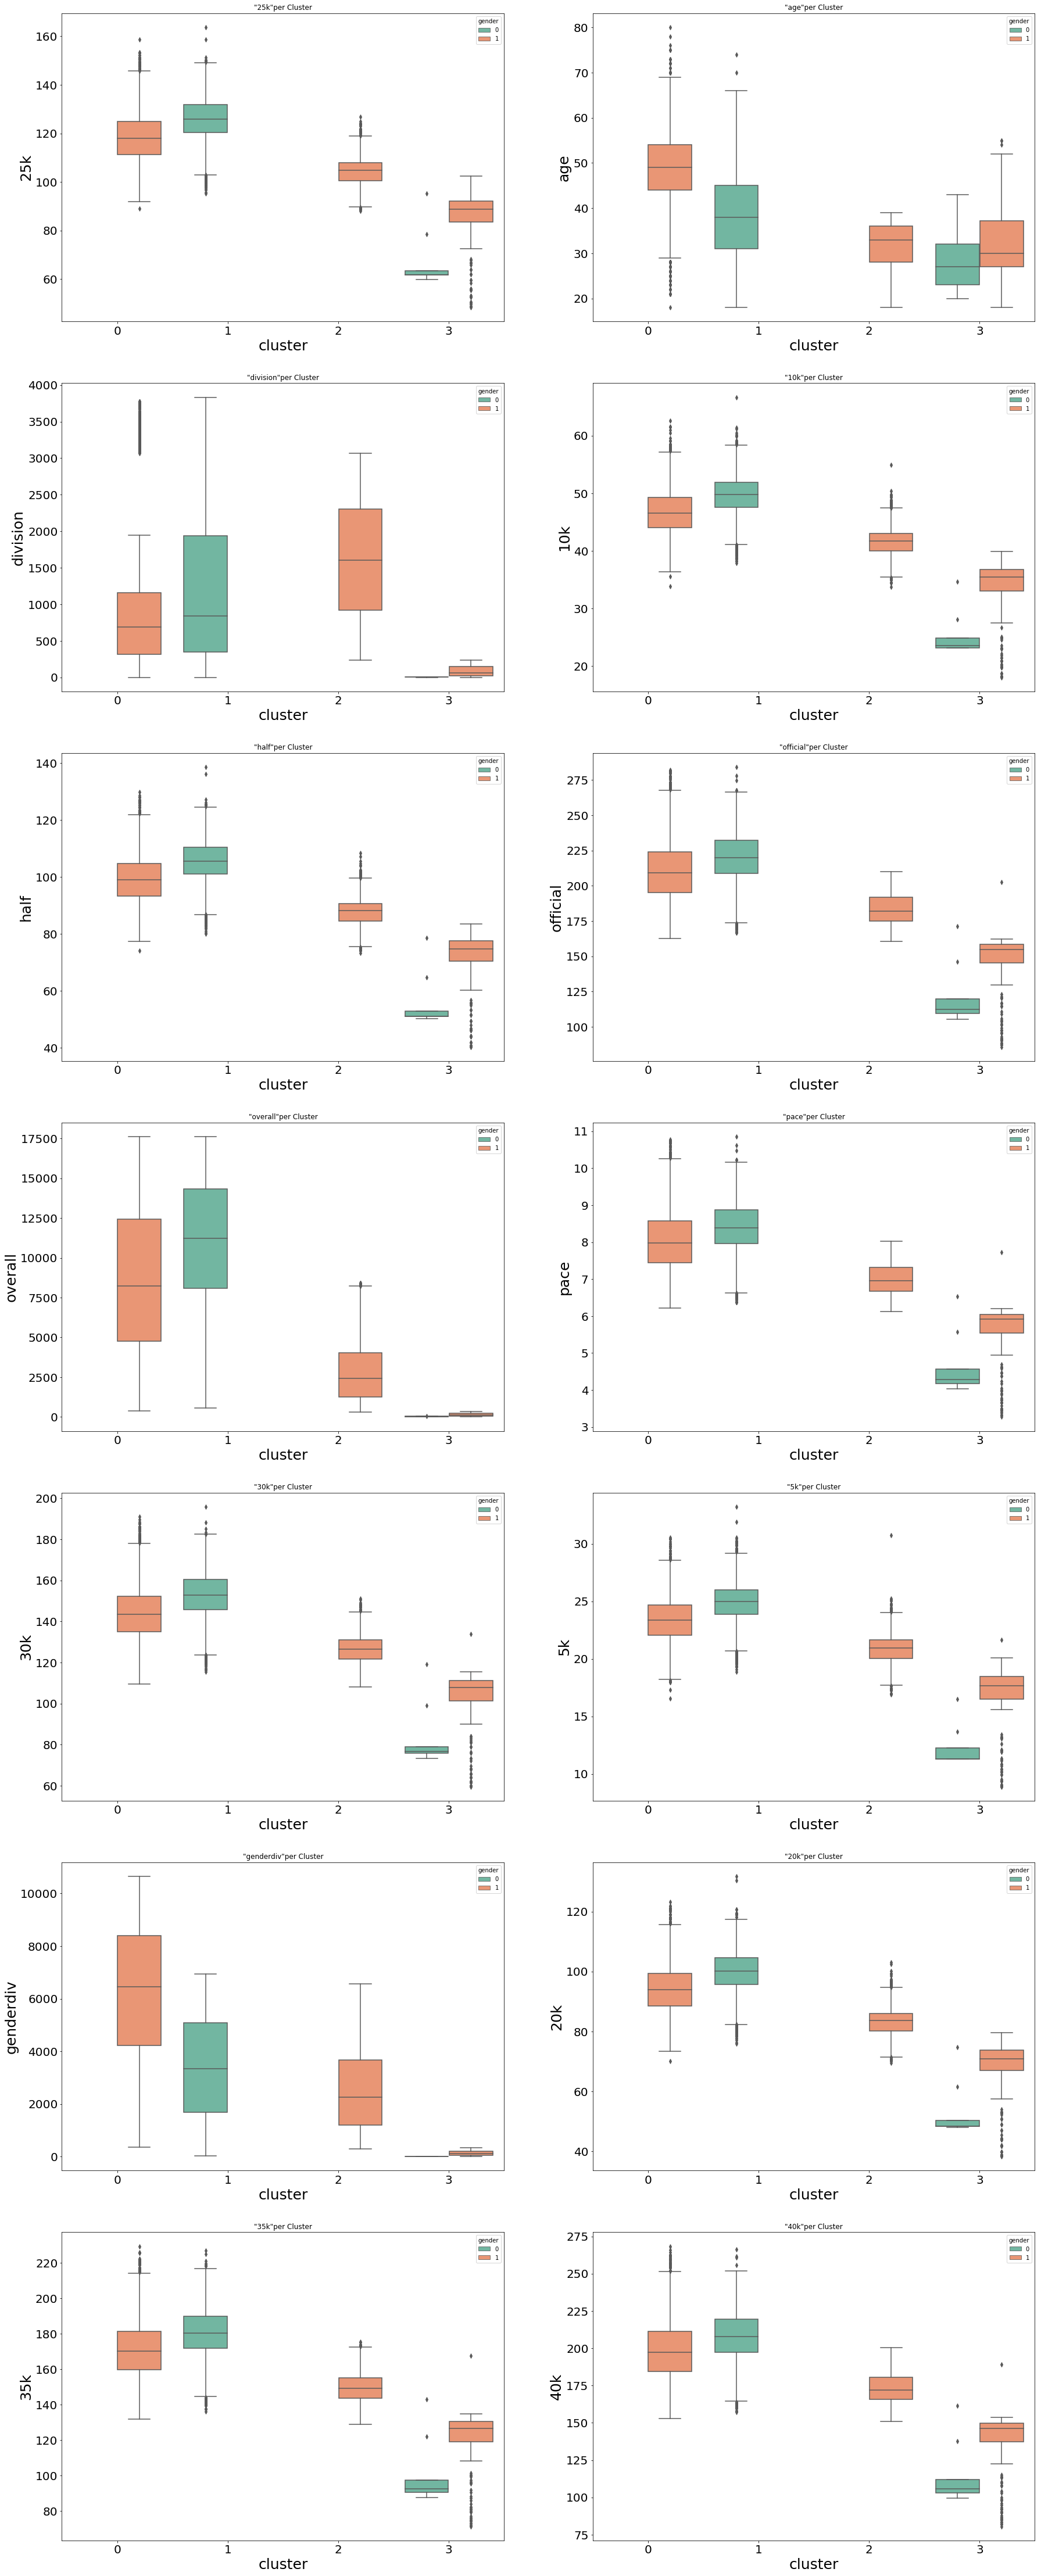

In [48]:
kmeansModel.showContBoxPlots()

## Categorical Feature Plots

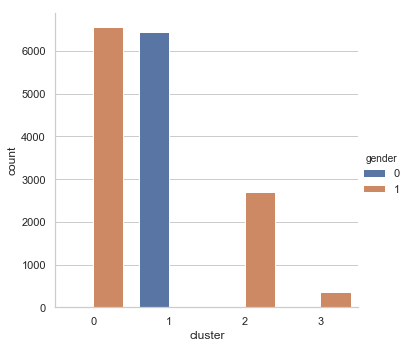

In [49]:
kmeansModel.showCatGraphs()

# Mean-shift

In [72]:
bandwidth = estimate_bandwidth(Xnorm, quantile=0.2, n_samples=500)

In [60]:
cols = np.array(dfNoNulls.columns.values)
catCols = ['gender']
contCols = cols[cols!='gender']

meanShiftParams = {'bandwidth': bandwidth,
              'bin_seeding': True}

In [61]:
meanShiftModel = ClusterModel(X, MeanShift(), catCols, contCols, **meanShiftParams)

## Silhouette Scores So Far

In [64]:
meanShiftModel.silScore()

[0.62816906790936367, 0.59958152608103188, 0.60089413574850492, 0.62964039816326933]
RANGE: 0.030058872082237453
CLUSTERS: 4


In [65]:
kmeansModel.silScore()

[0.63326765027740684, 0.63179673293316829, 0.63075493267445082, 0.63003781363974287]
RANGE: 0.003229836637663963
CLUSTERS: 4


## Continuous and Categorical Plots

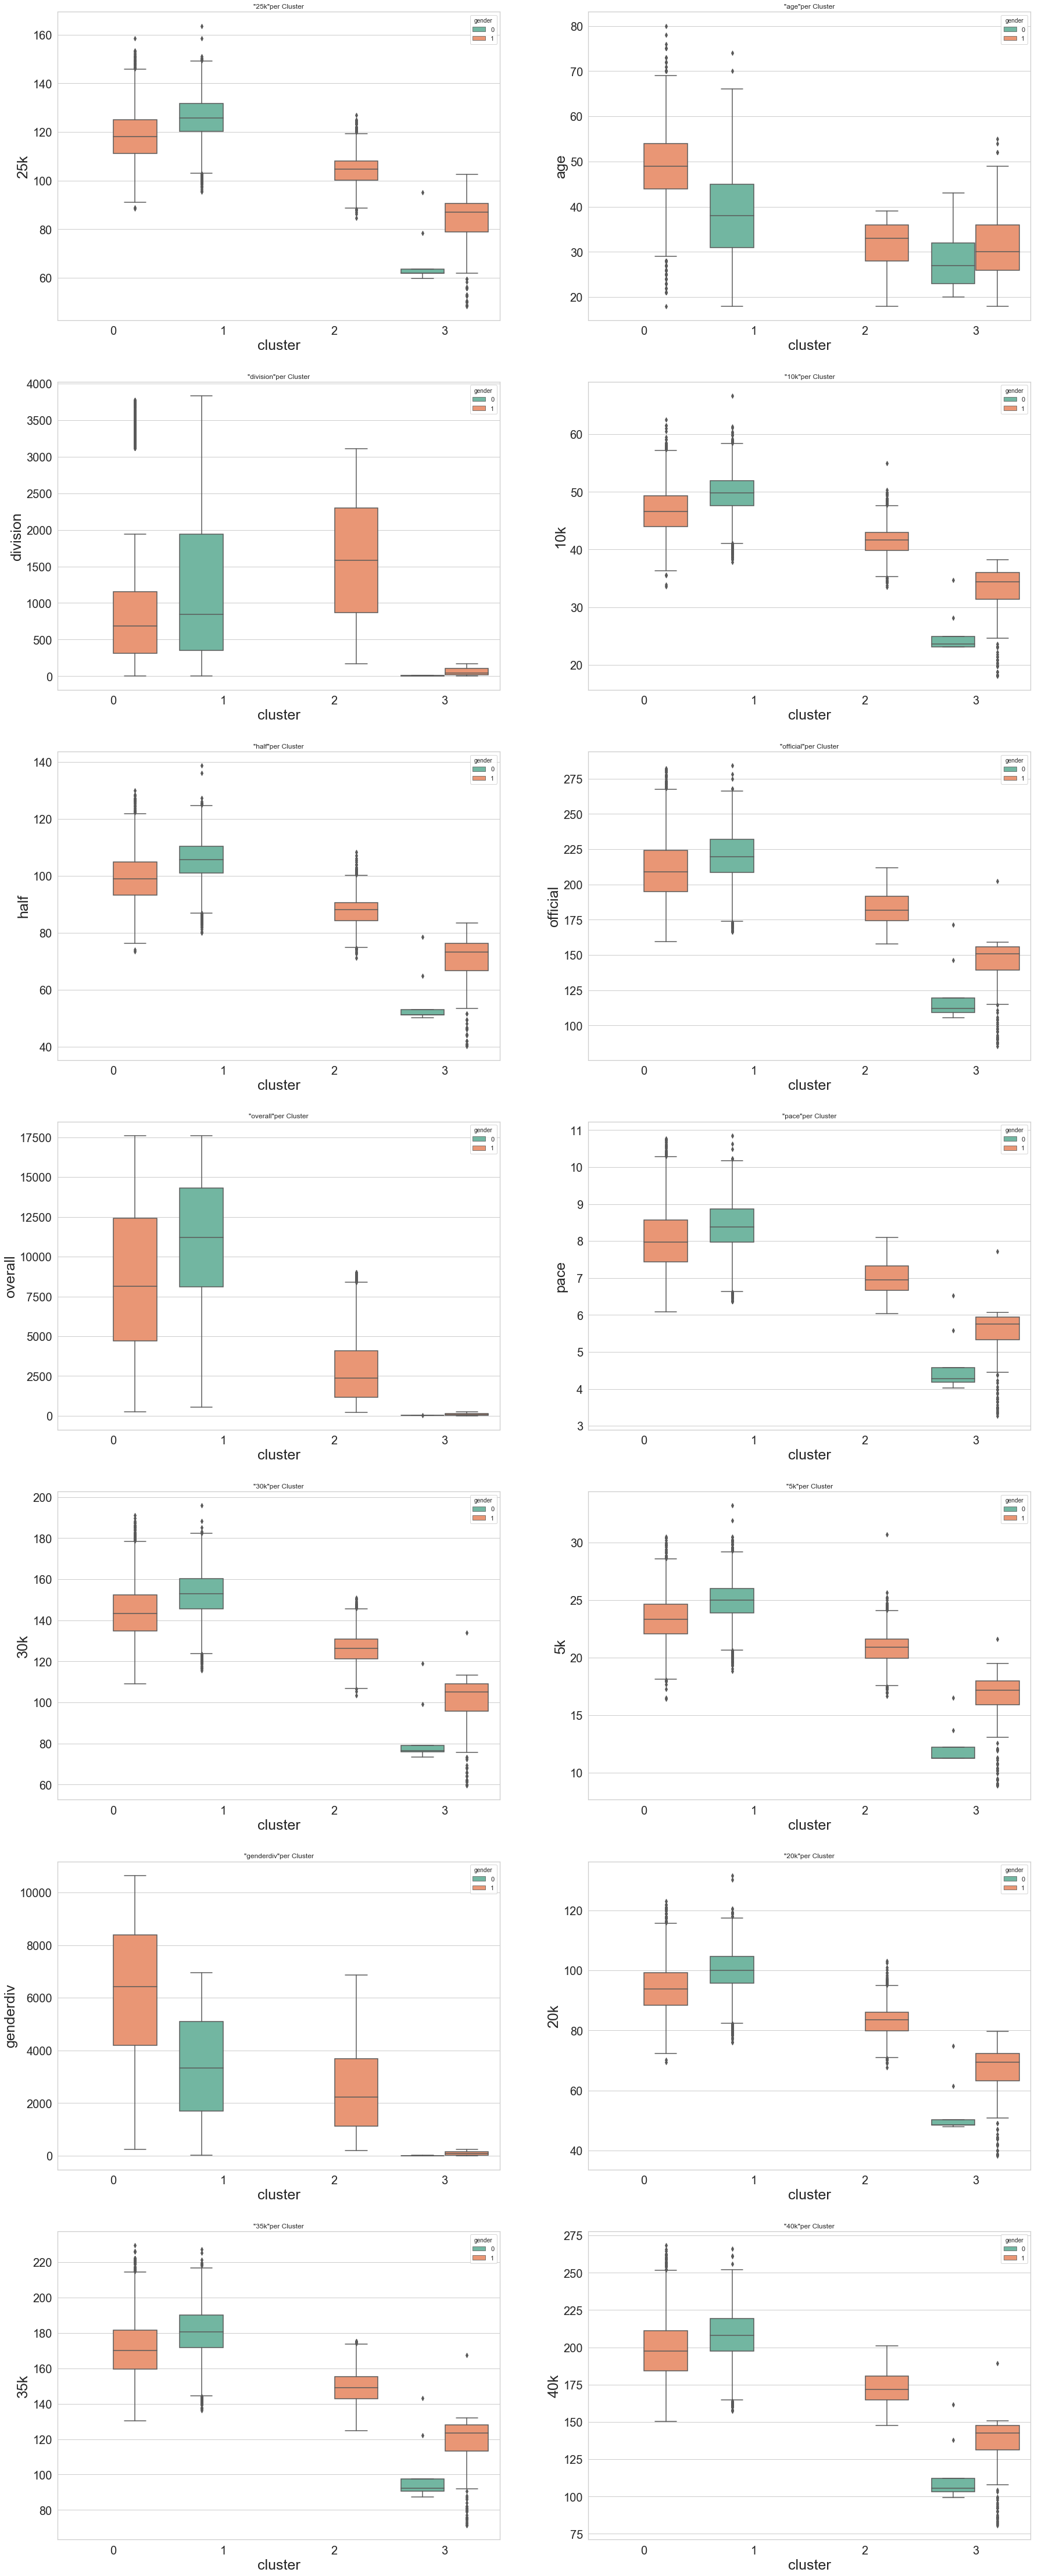

In [67]:
meanShiftModel.showContBoxPlots()

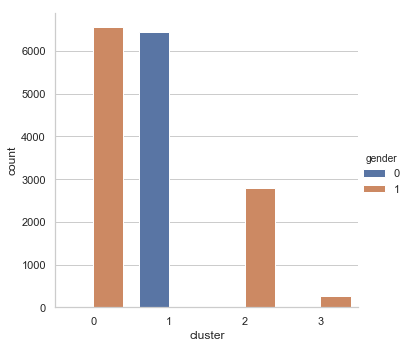

In [68]:
meanShiftModel.showCatGraphs()

# Spectral

In [71]:
sc = SpectralClustering(n_clusters=2)
sc.fit(Xnorm)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
          eigen_solver=None, eigen_tol=0.0, gamma=1.0, kernel_params=None,
          n_clusters=2, n_init=10, n_jobs=1, n_neighbors=10,
          random_state=None)

In [73]:
cols = np.array(dfNoNulls.columns.values)
catCols = ['gender']
contCols = cols[cols!='gender']

spectralParams = {'n_clusters': 4}

In [74]:
spectralModel = ClusterModel(X, SpectralClustering(), catCols, contCols, **spectralParams)

## Silhouette Scores So Far

In [75]:
spectralModel.silScore()

[0.63252422822392229, 0.63156901896458728, 0.62954071161690583, 0.62899143620568376]
RANGE: 0.0035327920182385286
CLUSTERS: 4


In [76]:
kmeansModel.silScore()

[0.63326765027740684, 0.63179673293316829, 0.63075493267445082, 0.63003781363974287]
RANGE: 0.003229836637663963
CLUSTERS: 4


In [77]:
meanShiftModel.silScore()

[0.62816906790936367, 0.59958152608103188, 0.60089413574850492, 0.62964039816326933]
RANGE: 0.030058872082237453
CLUSTERS: 4


## Continuous and Categorical Plots

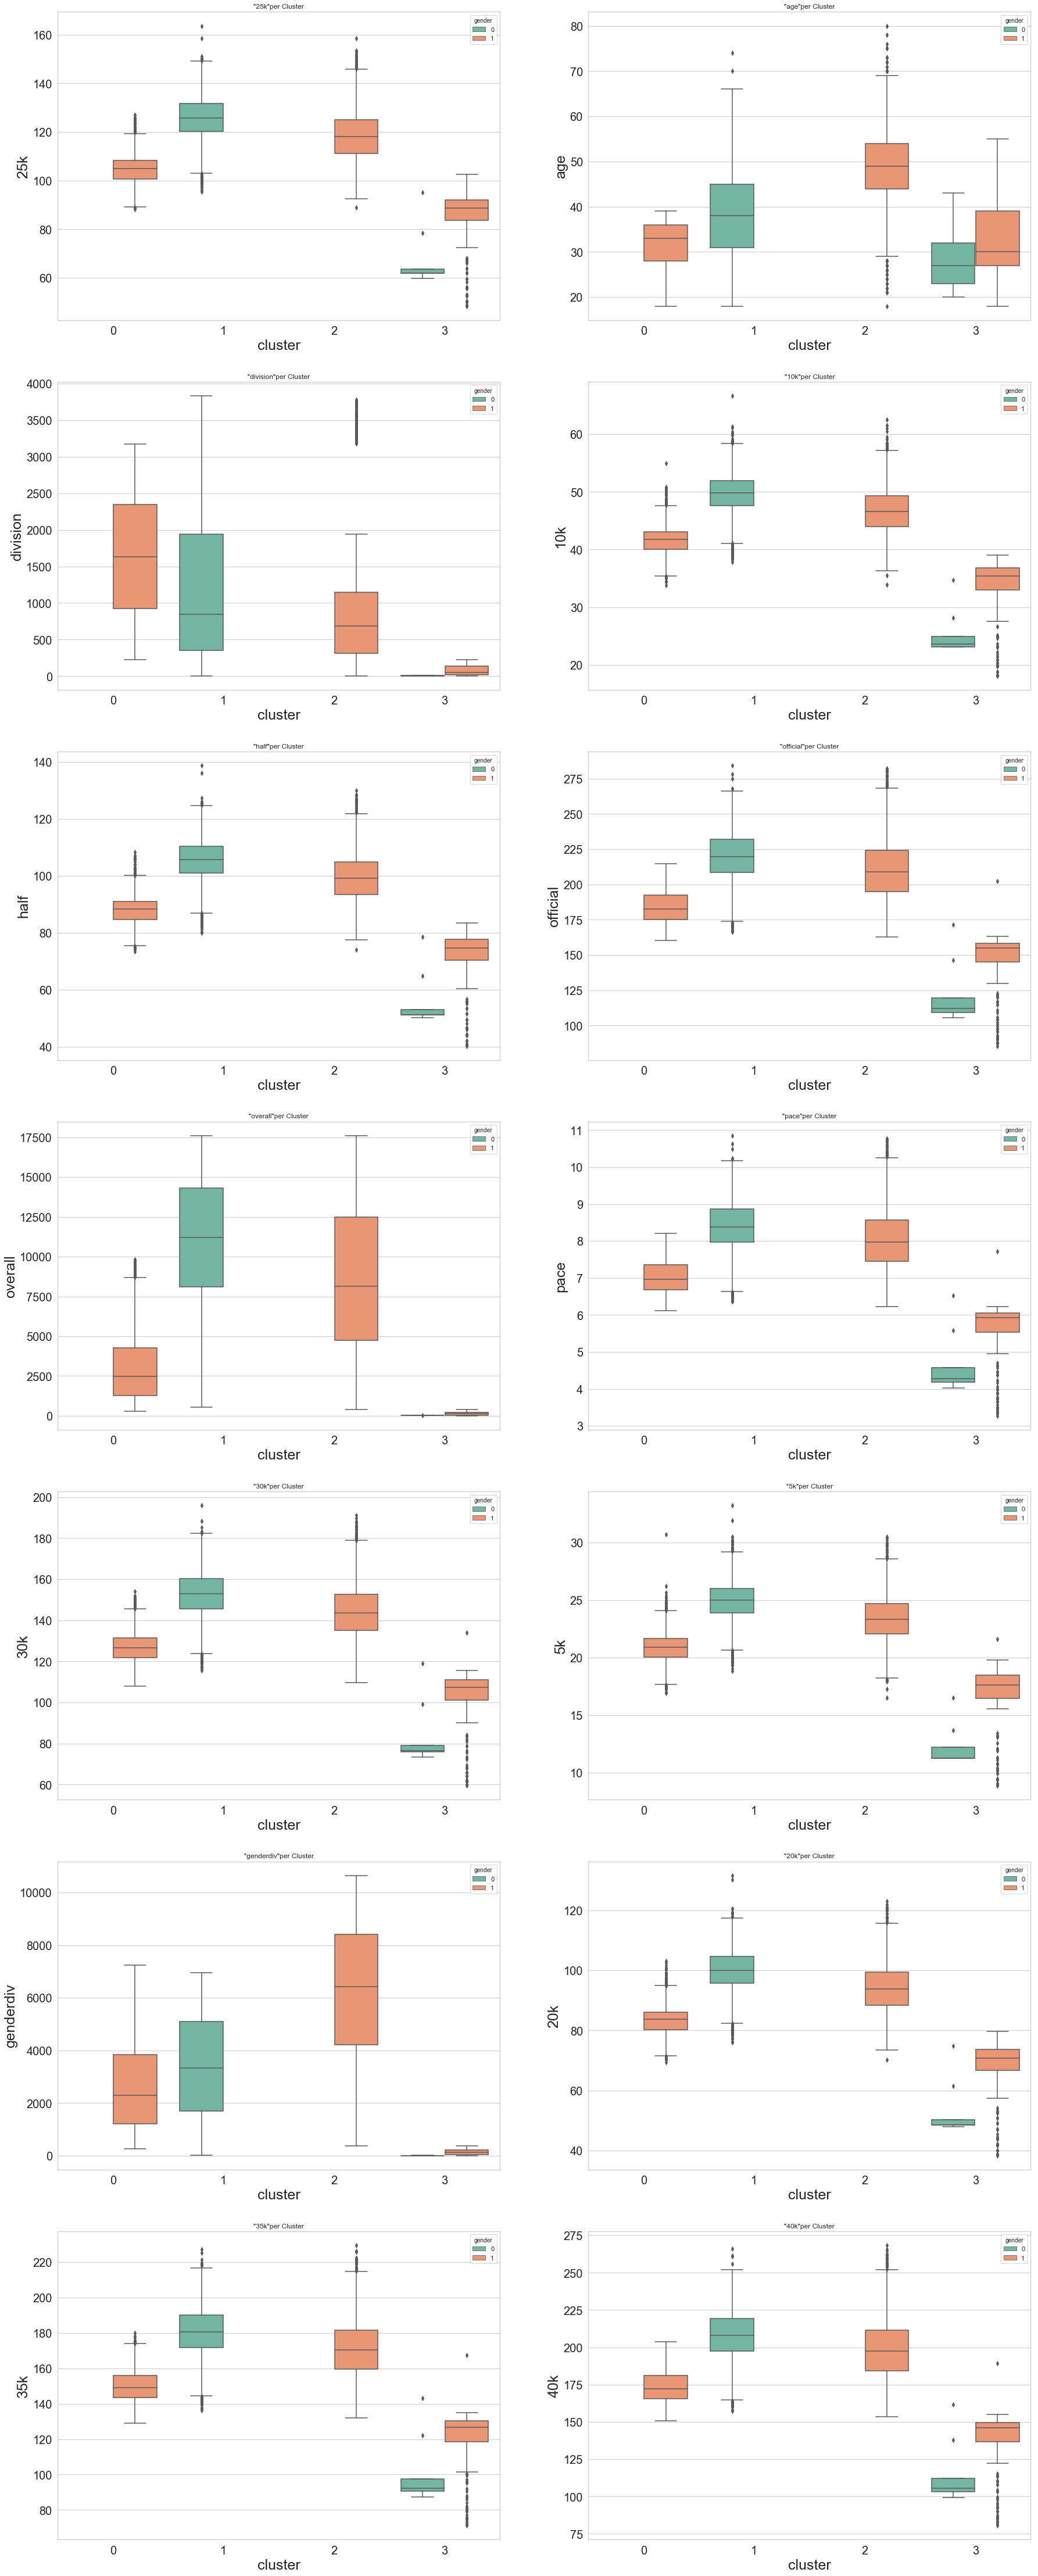

In [79]:
spectralModel.showContBoxPlots()

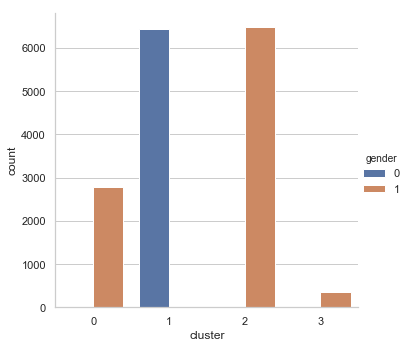

In [80]:
spectralModel.showCatGraphs()

# Affinity

In [ ]:
af = AffinityPropagation().fit(Xnorm)